# Unsupervised Learning: Exercise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**1.** Apply $K$-means and Mixtures of Gaussians to a dataset which may have some cluster structure.

In [2]:
from sklearn import datasets
# Generate synthetic datasets for clustering

n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)

In [3]:
dataset_choice = 3  # Change this to select dataset: 1=circles, 2=moons, 3=blobs
IDEAL_CLUSTERS = 3  # Ideal number of clusters for the datasets

datasets = {
    1: noisy_circles,
    2: noisy_moons, 
    3: blobs
}

# Select the dataset
selected_dataset = datasets[dataset_choice]
X = selected_dataset[0]
C = selected_dataset[1]

N, D = X.shape
print(f"Dataset {dataset_choice} shape: {N} samples, {D} dimensions")

Dataset 3 shape: 500 samples, 2 dimensions


In [4]:
class KMeans:
    """K-Means clustering"""
    def __init__(self, data, K=2):
        """data: NxD data matrix
        K: number of clusters"""
        self.X = data  # store dataset
        self.N, self.D = data.shape  # data dimensions
        self.K = K  # number of clusters
        self.C = np.zeros(self.N, dtype=int)   # cluster indices for data points
        self.R = np.zeros((self.N,self.K), dtype=int)   # indicator matrix
        self.Mu = data[np.random.randint(0, self.N, self.K),:]   # pick K points randomly
        
    def update(self):
        # Re-assign to clusters
        self.R[:] = 0  # clear the indicator variables
        for n in range(self.N):
            # check the distances
            dist = [ np.sum((self.X[n]-self.Mu[k])**2) for k in range(self.K)]
            # find the nearest mean
            self.C[n] = np.argmin(dist)  # new cluster assignment
            self.R[n, self.C[n]] = 1  # new indicator variable
        # Update the means
        for k in range(self.K):
            self.Mu[k] = self.R[:,k]@self.X/np.sum(self.R[:,k])
    
    def run(self, imax=20):
        """repeat until convergence"""
        for i in range(imax):
            R0 = self.R.copy() # previous indicators
            self.update()
            if np.array_equal(self.R, R0):
                print('converged with iteration', i)
                break
        return self.C, self.R, self.Mu

In [5]:
# initialize the algorithm
km = KMeans(X, K=IDEAL_CLUSTERS)
print( km.N, km.D, km.K)

500 2 3


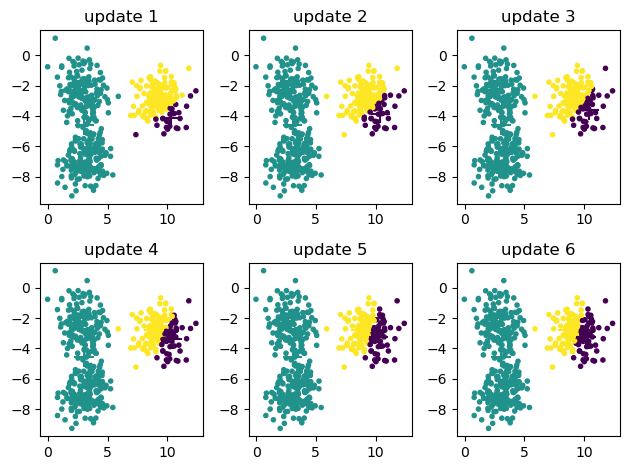

In [6]:
km = KMeans(X, K=IDEAL_CLUSTERS)
up = 6  # updates
for u in range(up):
    km.update()
    plt.subplot(2, int(np.ceil(up/2)), u+1)
    plt.title(f"update {u+1}")
    plt.scatter(X[:,0], X[:,1], c=km.C, marker='.')  # data colored by cluster
    plt.scatter(km.Mu[:,0], km.Mu[:,1], c=range(km.K), marker='+', s=200)  # means
plt.tight_layout()
plt.show()

In [7]:
from scipy.stats import multivariate_normal

class MixGauss:
    """MixGauss: Mixture of Gaussians"""
    def __init__(self, data, K=2):
        """X: NxD data matrix
        K: number of Gaussians"""
        self.X = data
        self.N, self.D = data.shape
        self.K = K
        self.Pi = np.ones(self.K)/self.K   # cluster probability
        self.R = np.zeros((self.N,self.K))   # responsibility matrix
        self.Mu = data[np.random.randint(0, self.N, self.K),:]   # pick K points randomly
        self.Sig = np.repeat(np.cov(data.T).reshape(1,self.D,self.D), self.K, axis=0)   # covariance for entire data

    def update(self):
        pr = np.zeros(self.K)   # data probability for each cluster
        """EM update"""
        # Expectation step
        for n in range(self.N):
            for k in range(self.K):
                pr[k] = multivariate_normal.pdf(self.X[n], self.Mu[k], self.Sig[k])
            # responsibility
            self.R[n,:] = pr/np.sum(pr)    # responsibility p(z)
        # Maximization step
        num = np.sum(self.R, axis=0);    # effective numbers for each class
        self.Pi = num/self.N    # class prior
        for k in range(self.K):
            self.Mu[k,:] = np.sum(self.R[:,k]*self.X.T, axis=1)/num[k]
            dX = self.X - self.Mu[k,:]
            self.Sig[k] = self.R[:,k]/num[k]*dX.T@dX  # cluster covariance    

    def fit(self, imax=100, conv=1e-6):
        """repeat until convergence"""
        for i in range(imax):
            R0 = self.R.copy()
            self.update()
            #print(self.R, R0)
            if np.sum(abs(self.R-R0))/self.N < conv:
                print('converged with iteration', i)
                break
        return self.R, self.Mu, self.Sig

converged with iteration 61


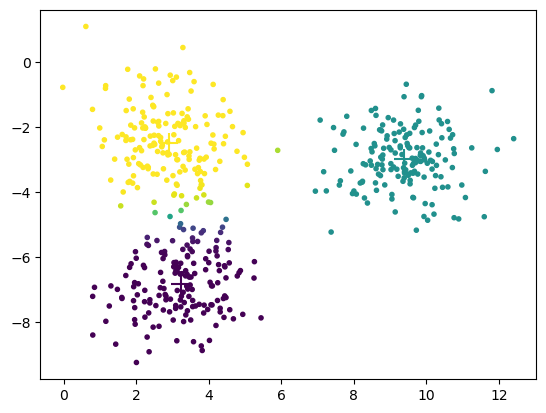

In [8]:
mg = MixGauss(X, IDEAL_CLUSTERS)
mg.fit()
plt.scatter(X[:,0], X[:,1], c=np.dot(mg.R,np.arange(mg.K)), marker='.')
plt.scatter(mg.Mu[:,0], mg.Mu[:,1], c=range(mg.K), marker='+', s=200)  # means
plt.show()

**2.** Apply PCA and SVD to a high-dimensional dataset of your interest and compare the results.

**3.** Apply ICA to a mixted signal of your interest and whether it can separate the original signals.

In [9]:
def ica(X, W=None, alpha=0.01, online=True):
    """ICA by max entropy with tanh()"""
    N, D = X.shape
    if W is None:
        W = np.eye(D)  # initial guess
    if online:
        for n in range(N):
            u = W@X[n,:]  
            y = np.tanh(u)
            W += alpha*(W - np.outer(y,u@W))
    else:  # batch update
        U = X@W.T
        Y = np.tanh(U)
        W += alpha*(W - Y.T@U@W/N)
    return W

In [13]:
import numpy as np
from scipy import signal

np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
D = A.shape[0]  # Number of sources
X = np.dot(S, A.T)  # Generate observations

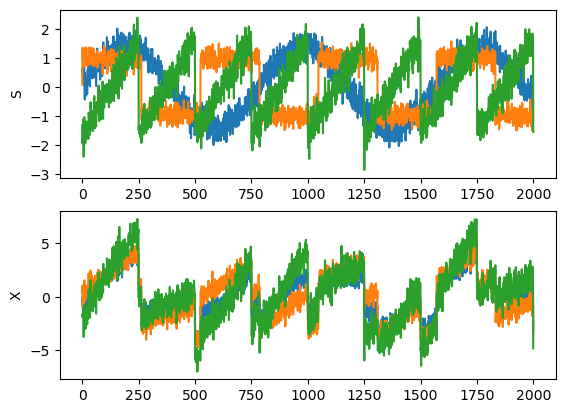

In [14]:
plt.subplot(2, 1, 1)
plt.plot(S)
plt.ylabel("S")
# Mixed signal
plt.subplot(2, 1, 2)
plt.plot(X)
plt.ylabel("X")
plt.show()

In [15]:
# Applyy ICA to the mixture
W = np.eye(D)
for k in range(10):
    W = ica(X, W, alpha=0.001)
U = X@W.T
Y = np.tanh(U)

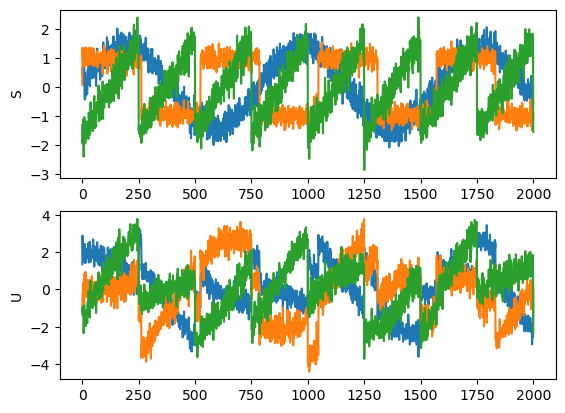

In [16]:
# plot the original and separated signals
plt.subplot(2, 1, 1)
plt.plot(S)
plt.ylabel("S")
plt.subplot(2, 1, 2)
plt.plot(U)
plt.ylabel("U")
plt.show()

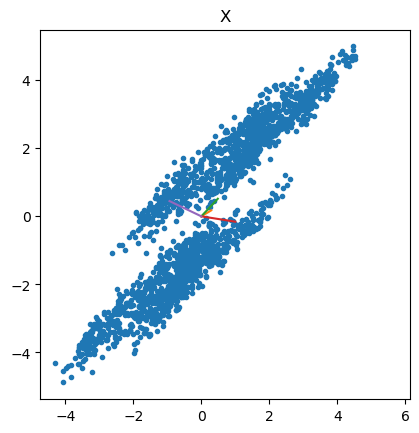

In [17]:
# see how the mixing and separation weights are aligned to mixed data
plt.plot(X[:,0], X[:,1], '.')
plt.axis('square')
plt.title("X")
# estimated mixing vectors
a = np.linalg.inv(W)
a = a/np.max(abs(a))
plt.plot([0, a[0,0]], [0, a[0,1]])
plt.plot([0, a[1,0]], [0, a[1,1]])
# separating vectors
w = W/np.max(W)
plt.plot([0,w[0,0]], [0,w[0,1]])
plt.plot([0,w[1,0]], [0,w[1,1]])
plt.show()